# Testing the four models

##### In this script, the following four models are tested:
1. **Model 1:** trained on 1% of the training data
2. **Model 2:** trained on 10% of the training data
3. **Model 3:** trained on 25% of the training data

All the models here are variants of GPT-2 and identical in size.

#### The following tests are conducted on the fours models:
1. Correctness of moves made
2. Knight's tour completion for all indices
3. Diversity of moves made
4. Capacity to solve Parberry tours

In [1]:
import torch
import polars as pl
import numpy as np
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel
from torch.utils.data import DataLoader
from plotting_preferences_AS import plotting_preferences_AS

In [3]:
#plotting_preferences_AS()

In [4]:
np.random.seed(23425409)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
model_dirs = [
    "./training/results/checkpoint-8080/",
    "./trained10/results/checkpoint-8000/",
    "./trained25/results/checkpoint-76000/",
]

In [6]:
model1 = GPT2LMHeadModel.from_pretrained(model_dirs[0])
model2 = GPT2LMHeadModel.from_pretrained(model_dirs[1])
model3 = GPT2LMHeadModel.from_pretrained(model_dirs[2])

model1.eval()
model2.eval()
model3.eval()

model1.to(device)
model2.to(device)
model3.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(64, 768)
    (wpe): Embedding(64, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=64, bias=False)
)

In [7]:
def draw_chessboard(
    ax,
    board_l,
    board_h
):
    """
    This script draws a nxn chessboard.
    
    :param ax: matplotlib axes
    :param board_l: length of the chessboard
    :param board_h: height of the chessboard
    :return: an board_l x board_h empty chessboard
    """
    # drawing squares 
    for y in range(board_h):
        for x in range(board_l):
            rectangle = patches.Rectangle(
                (x, y), 1, 1, 
                linewidth=1, 
                edgecolor='green', 
                facecolor='white' if (x + y) % 2 == 0 else 'lightgreen'
            )
            
            ax.add_patch(rectangle)
    

    ax.set_xlim(0, board_l)
    ax.set_ylim(0, board_h)
    
    ax.set_xticks(np.arange(0, board_l, 1))
    ax.set_yticks(np.arange(0, board_h, 1))
    
    ax.grid(False)
    
    # equal aspect ratio for the squares
    ax.set_aspect('equal')

    
def plot_knights_tour(
    tour, 
    board_l=8, 
    board_h=8, 
    save=False,
    save_path=""
):
    """
    This function plots the provided tour on a chessboard.
    
    This function was partly generated with the help of GPT-4o. 
    The prompt used was: "For a sequence of knight't tour represented 
    by indices ranging from 0-63, could you create a function that draws
    the tour on a 2D chessboard that is made using this function
    {insert draw_chessboard(ax, board_l, board_h)}"
    
    
    :param tour: A 1D sequence with the knight's tour
    :param board_l: length of the chessboard
    :param board_h: height of the chessboard
    :param board_h: height of the chessboard 
    :param save: a boolean indicating if the plotted tour should be saved
    :param save_path: path where the image should be saved
    :return: A board_l x board_h chessboard with the tour marked
    """

    # finding 2D board positions from the indices
    coordinates = [(move % board_l, move // board_l) for move in tour]
    

    fig, ax = plt.subplots(figsize=(board_l, board_h))
    
    # drawing the chessboard
    draw_chessboard(ax, board_l, board_h)
    
    ax.set_xlim(0, board_l)
    ax.set_ylim(0, board_h)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # scaling the size of the text and 
    scaling_factor = 0.3 * (board_h * board_l) / 8
    head_width = 0.2 / scaling_factor
    head_length = 0.2 / scaling_factor
    text_offset = 0.2 / scaling_factor
    radius = 0.3 / scaling_factor
    fontsize = 8 / scaling_factor
    
    # drawing the moves
    for i in range(len(coordinates) - 1):
        start_pos = coordinates[i]
        end_pos = coordinates[i + 1]
        
        # drawing consecutive arrows 
        ax.arrow(
            start_pos[0] + 0.5, start_pos[1] + 0.5,
             end_pos[0] - start_pos[0], 
             end_pos[1] - start_pos[1],
             head_width=head_width,
             head_length=head_length, 
             fc='blue', ec='blue', 
             length_includes_head=True, 
             alpha=0.75
        )
        
        #ax.text(start_pos[0] + text_offset, start_pos[1] + text_offset, 
        #        str(i + 1), color='darkred', fontsize=fontsize)
    
    ax.add_patch(patches.Circle((coordinates[0][0] + 0.5, coordinates[0][1] + 0.5), 
                                radius, color='green', label='Start'))
    ax.add_patch(patches.Circle((coordinates[-1][0] + 0.5, coordinates[-1][1] + 0.5), 
                                radius, color='darkred', label='End'))

    # labels and title
    ax.legend(loc="upper right")
    plt.title(f"GPT-2 variant knight\'s tour")
    
    if not save:
        plt.show()
    else:
        plt.savefig(f"{save_path}", dpi=300, bbox_inches="tight")

In [8]:
# loading "test" sets
test1 = pl.read_parquet("./data/test/test_point1_pos9_tours_8x8_1036807.parquet")
test2 = pl.read_parquet("./data/test/test_point2_pos11_tours_8x8_1078882.parquet")
test3 = pl.read_parquet("./data/test/test_point3_pos2_tours_8x8_8053708.parquet")

### Checking model performance from random starting positions

In [9]:
# random starting position
i = np.random.randint(len(test1))
i

999147

In [10]:
starting_position = test1.row(i)[:1] #[9] 
print(starting_position)

(9,)


In [11]:
# converting to tensor
input_ids = torch.tensor([starting_position]).to("cuda:0")

In [12]:
generated_ids = model3.generate(
    input_ids=input_ids,
    max_length=64,
    #num_beams=5,  
    temperature=1,
    do_sample=True,
    #top_p=64       
)

# token IDs to list
generated_moves = generated_ids[0].tolist()
print(generated_moves)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[9, 3, 13, 7, 22, 5, 15, 30, 47, 62, 52, 58, 48, 33, 16, 1, 11, 26, 32, 49, 59, 53, 63, 46, 31, 14, 20, 37, 43, 60, 54, 39, 45, 55, 61, 51, 57, 40, 50, 56, 41, 24, 34, 28, 18, 8, 2, 17, 0, 10, 4, 19, 25, 35, 29, 23, 38, 44, 27, 12, 6, 21, 36, 42]


In [13]:
len(set(generated_moves))

64

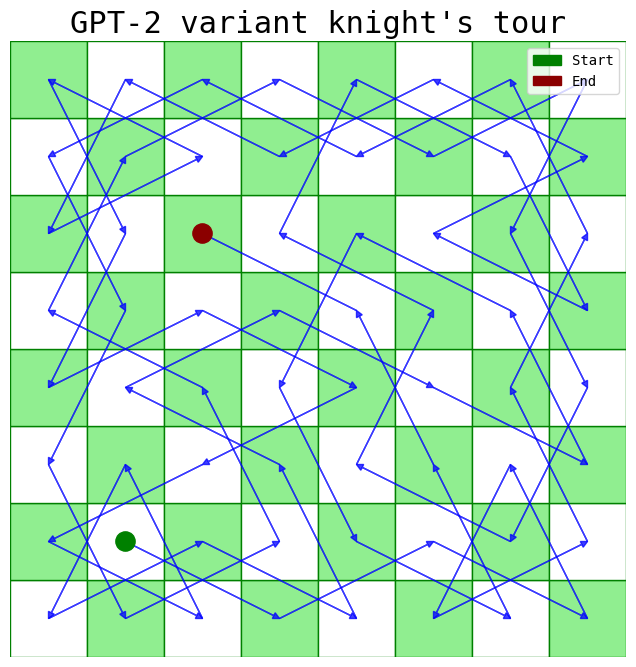

In [14]:
plot_knights_tour(generated_moves, board_l=8, board_h=8)

### Loading functions to check the tour

In [15]:
def knight_move(
        board, 
        start_index
):
    start_index_x, start_index_y = start_index
    
    possible_steps = {
        "up_and_right": [start_index_x + 1, start_index_y - 2],
        "up_and_left": [start_index_x - 1, start_index_y - 2],
        
        "right_and_up": [start_index_x + 2, start_index_y - 1],
        "right_and_down": [start_index_x + 2, start_index_y + 1],
        
        "left_and_up": [start_index_x - 2, start_index_y - 1],
        "left_and_down": [start_index_x - 2, start_index_y + 1],
        
        "down_and_right": [start_index_x + 1, start_index_y + 2],
        "down_and_left": [start_index_x - 1, start_index_y + 2],
    }
    
    possible_moves = []
    
    for step in possible_steps.keys():
        index_x, index_y = possible_steps.get(step)
        
        if index_x >= 0 and index_y >= 0:
            try:
                possible_moves.append(board[index_x][index_y])
            except IndexError:
                pass
            
    return possible_moves


board_size = 8

chessboard_nxn = [
    [i for i in range(n, n + board_size)] 
    for n in range(0, board_size ** 2, board_size)
]

chessboard_nxn_indices = [
    [i, j] for i in range(board_size) 
    for j in range(board_size)
]

adjacency_list = {
    i: j for i, j in zip(
        range(board_size ** 2), 
        list(
            knight_move(chessboard_nxn, index) 
            for index in chessboard_nxn_indices)
    )
}

def solution_check(
    tour
):
    """
    Checks if no repeated moves are made in the tour
    """
    return True if tour and len(tour) == len(set(tour)) else False 

def tour_check(
    tour, 
    adjacency_grid=adjacency_list
):
    """
    Checks validity of all moves in a tour
    """
    for i in range(len(tour) - 1):
        if tour[i + 1] not in adjacency_grid[tour[i]]:
            return False
    return True

def check_if_tour_closed(
    tour, 
    adjacency_grid=adjacency_list
):
    """
    Checks if the solved tour is open or closed
    """
    return True if tour[-1] in adjacency_grid[tour[0]] else False

### Loading Parberry tours

In [25]:
parberry = pl.read_parquet(
    "./parberry/tours_8x5_2900_20241208.parquet"
).rows()

# choosing only tours which can be continued
# tours that end on the lower end of the chessboard
# have no subsequent valid moves
parberry_all = [i for i in parberry if i[-1] in np.arange(24, 40)]
parberry_subset = [i for i in parberry if i[-1] in np.arange(32, 40)]
parberry_subset2 = [i for i in parberry if i[-1] in np.arange(24, 32)]

print(
    len(parberry_all),
    len(parberry_subset),
    len(parberry_subset2)
)

1191 774 417


### Correctness and completion of tours

In [49]:
def generate_tours_from_gpt(
    model_name,
    total_to_generate=1,
):
    df_dict = {
        "tour_index": [],
        "correct_tour": [],
        "tour": [],
    }

    with tqdm(total=int(total_to_generate * 64), desc='Loop number') as pbar:
        for _ in range(total_to_generate):
            tour_indices = list(range(64))

            for starting_position in tour_indices:

                input_ids = torch.tensor([[starting_position]]).to("cuda:0")

                generated_ids = model_name.generate(
                    input_ids=input_ids,
                    max_length=64,
                    temperature=1,
                    pad_token_id=63,
                    attention_mask=torch.ones_like(input_ids)
                )

                # token IDs to list
                generated_moves = tuple(generated_ids[0].tolist())

                df_dict["tour_index"].append(starting_position)
                df_dict["correct_tour"].append(True if tour_check(generated_moves) else False)
                df_dict["tour"].append(generated_moves)
                
                pbar.update(1)
        
    df_dict_df = pl.DataFrame(df_dict)
    
    return df_dict_df

In [ ]:
model1_results = generate_tours_from_gpt(model1)

In [72]:
model2_results = generate_tours_from_gpt(model2)

Loop number: 100%|██████████| 64/64 [00:36<00:00,  1.78it/s]


In [50]:
model3_results = generate_tours_from_gpt(model3)

Loop number: 100%|██████████| 64/64 [00:30<00:00,  2.11it/s]


In [66]:
model1_results["correct_tour"].unique()

tour_index,correct_tour,tour
i64,bool,list[i64]
0,true,"[0, 10, … 46]"
1,true,"[1, 16, … 31]"
2,true,"[2, 8, … 42]"
3,true,"[3, 9, … 11]"
4,true,"[4, 14, … 7]"
…,…,…
59,true,"[59, 49, … 28]"
60,true,"[60, 54, … 0]"
61,true,"[61, 55, … 17]"


### Correctness of moves

In [67]:
model1_results["correct_tour"].unique()

correct_tour
bool
true


In [74]:
model2_results["correct_tour"].unique()

correct_tour
bool
true


In [75]:
model2_results["correct_tour"].unique()

correct_tour
bool
true


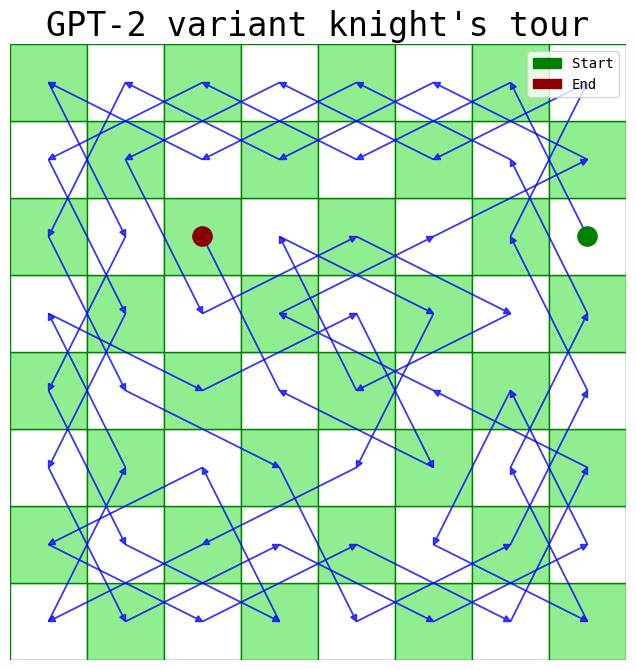

In [121]:
random_id = np.random.randint(len(model1_results))
plot_knights_tour(model1_results["tour"][random_id])

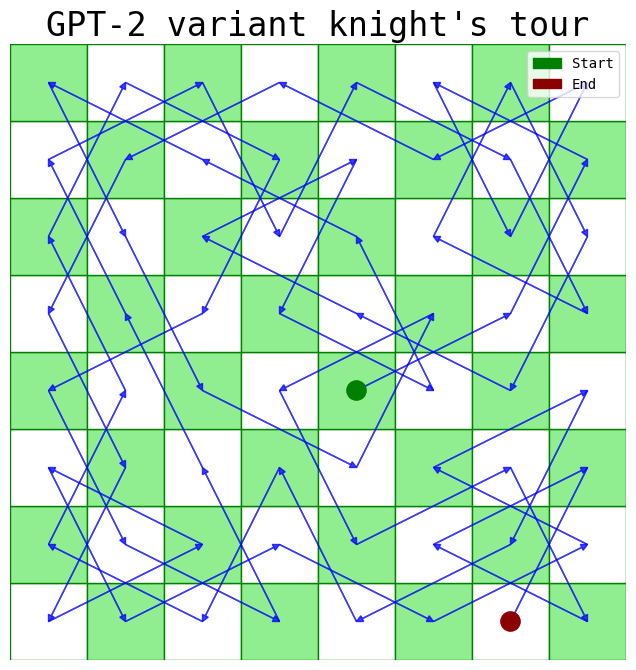

In [122]:
random_id = np.random.randint(len(model1_results))
plot_knights_tour(model2_results["tour"][random_id])

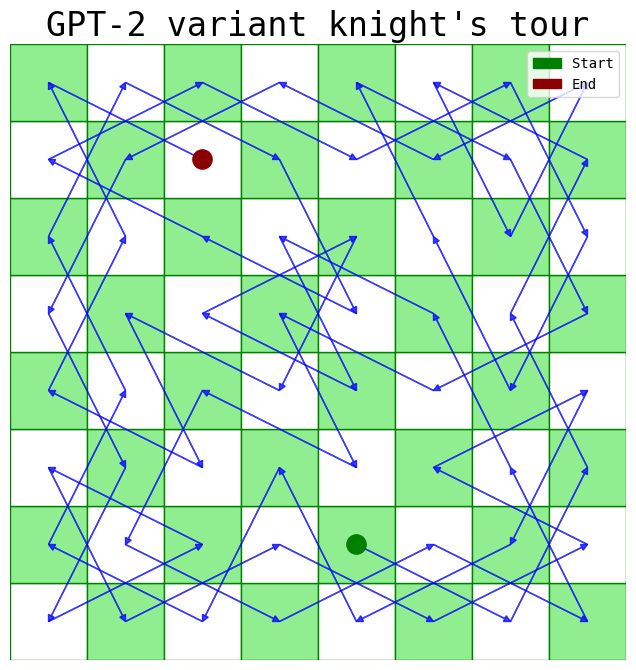

In [123]:
random_id = np.random.randint(len(model1_results))
plot_knights_tour(model3_results["tour"][random_id])

Tours from every single starting position is correctly solved!

### Can the model reliably solve the tour from the 9th index?
As there weren't any tours beginning from this index in the training data.

In [128]:
def check_ninth_index(model_name, which_tour=0):
    correct = 0
    
    for given_moves in tqdm(range(1, 63)):
        partial_tour = test1.row(which_tour)[:given_moves]
        input_ids = torch.tensor([partial_tour]).to("cuda:0")

        generated_ids = model_name.generate(
            input_ids=input_ids,
            max_length=64,
            temperature=1,
            pad_token_id=63,
            attention_mask=torch.ones_like(input_ids)
        )

        # token IDs to list
        generated_moves = tuple(generated_ids[0].tolist())

        if tour_check(generated_moves):
            correct += 1

    return correct

In [129]:
check_ninth_index(model1)

100%|██████████| 62/62 [00:14<00:00,  4.29it/s]


62

In [130]:
check_ninth_index(model2)

100%|██████████| 62/62 [00:16<00:00,  3.80it/s]


62

In [131]:
check_ninth_index(model3)

100%|██████████| 62/62 [00:18<00:00,  3.31it/s]


62

Interestingly, even `model1` which was trained on just 1% of all the data can reliably solve tours of varying provided lengths from the 9th index.

## Can it solve a Parberry tour?

In [20]:
def check_parberry(model_name, which_parberry=parberry_all):
    correct = 0
    
    for p in tqdm(which_parberry):
        input_ids = torch.tensor([p]).to("cuda:0")

        generated_ids = model_name.generate(
            input_ids=input_ids,
            max_length=64,
            temperature=1,
            pad_token_id=63,
            attention_mask=torch.ones_like(input_ids)
        )

        # token IDs to list
        generated_moves = tuple(generated_ids[0].tolist())

        if tour_check(generated_moves):
            correct += 1

    return correct

In [21]:
correct_parberry_model1 = check_parberry(model1, which_parberry=parberry_subset)
print(correct_parberry_model1)

100%|██████████| 774/774 [02:37<00:00,  4.90it/s]

521


In [22]:
correct_parberry_model2 = check_parberry(model2, which_parberry=parberry_subset)
print(correct_parberry_model2)

100%|██████████| 774/774 [02:22<00:00,  5.45it/s]

557


In [23]:
correct_parberry_model3 = check_parberry(model3, which_parberry=parberry_subset)
print(correct_parberry_model3)

100%|██████████| 774/774 [02:23<00:00,  5.38it/s]

594


In [32]:
correct_parberry_model1_full = check_parberry(model1)
print(correct_parberry_model1_full)

100%|██████████| 1191/1191 [03:43<00:00,  5.33it/s]

815


In [33]:
correct_parberry_model2_full = check_parberry(model2)
print(correct_parberry_model2_full)

100%|██████████| 1191/1191 [03:57<00:00,  5.02it/s]

822


In [34]:
correct_parberry_model3_full = check_parberry(model3)
print(correct_parberry_model3_full)

100%|██████████| 1191/1191 [03:49<00:00,  5.19it/s]

999


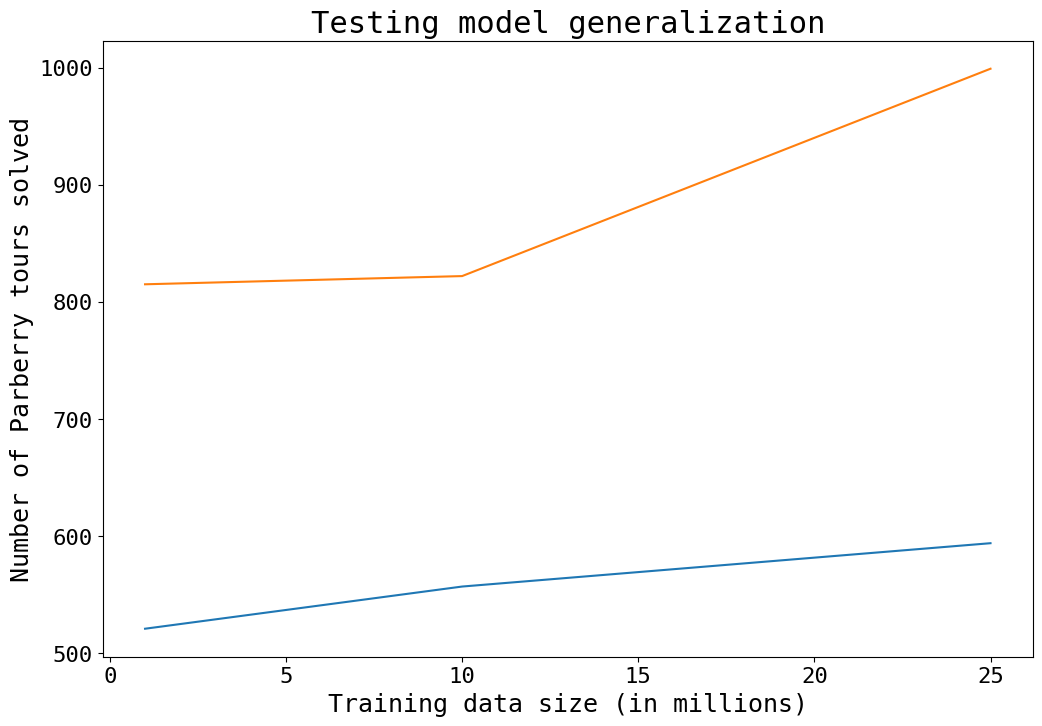

In [42]:
fig, ax = plt.subplots()

plt.plot(
    [1, 10, 25],
    [correct_parberry_model1, correct_parberry_model2, correct_parberry_model3]
)

plt.plot(
    [1, 10, 25],
    [
        correct_parberry_model1_full, 
        correct_parberry_model2_full, 
        correct_parberry_model3_full
    ]
)

plt.title("Testing model generalization")
plt.xlabel("Training data size (in millions)")
plt.ylabel("Number of Parberry tours solved")


plt.savefig(f"parberry_completion.png", dpi=300, bbox_inches="tight")

### Saving some parberry tour plots

In [38]:
input_ids = torch.tensor([parberry_all[0]]).to("cuda:0")

generated_ids = model3.generate(
    input_ids=input_ids,
    max_length=64,
    temperature=1,
    pad_token_id=63,
    attention_mask=torch.ones_like(input_ids)
)

# token IDs to list
generated_moves = tuple(generated_ids[0].tolist())

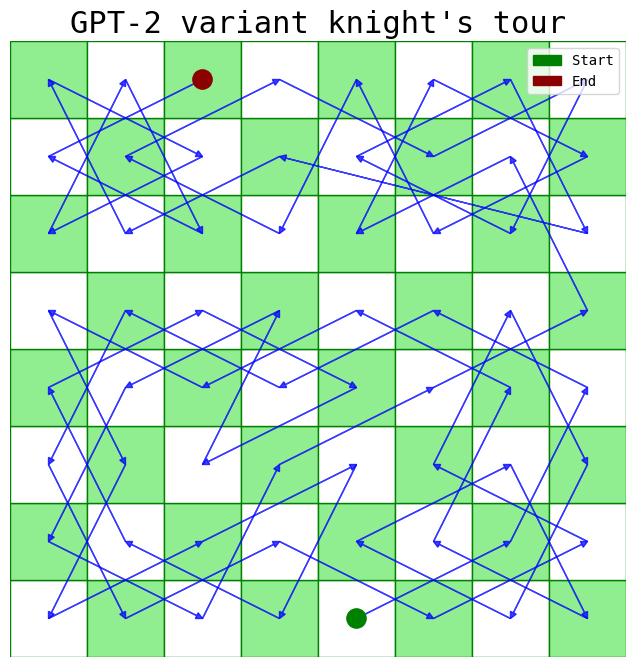

In [39]:
plot_knights_tour(
    generated_moves,
    save=True,
    save_path="./parberry_example1_model3.png"
)

In [40]:
input_ids = torch.tensor([parberry_all[1]]).to("cuda:0")

generated_ids = model3.generate(
    input_ids=input_ids,
    max_length=64,
    temperature=1,
    pad_token_id=63,
    attention_mask=torch.ones_like(input_ids)
)

# token IDs to list
generated_moves = tuple(generated_ids[0].tolist())

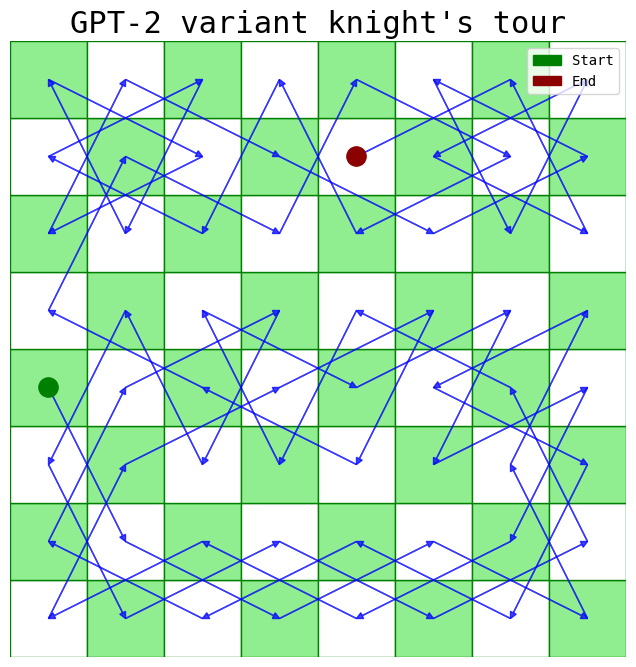

In [41]:
plot_knights_tour(
    generated_moves,
    save=True,
    save_path="./parberry_example2_model3.png"
)

In [45]:
input_ids = torch.tensor([parberry_all[3]]).to("cuda:0")

generated_ids = model3.generate(
    input_ids=input_ids,
    max_length=64,
    temperature=1,
    pad_token_id=63,
    attention_mask=torch.ones_like(input_ids)
)

# token IDs to list
generated_moves = tuple(generated_ids[0].tolist())

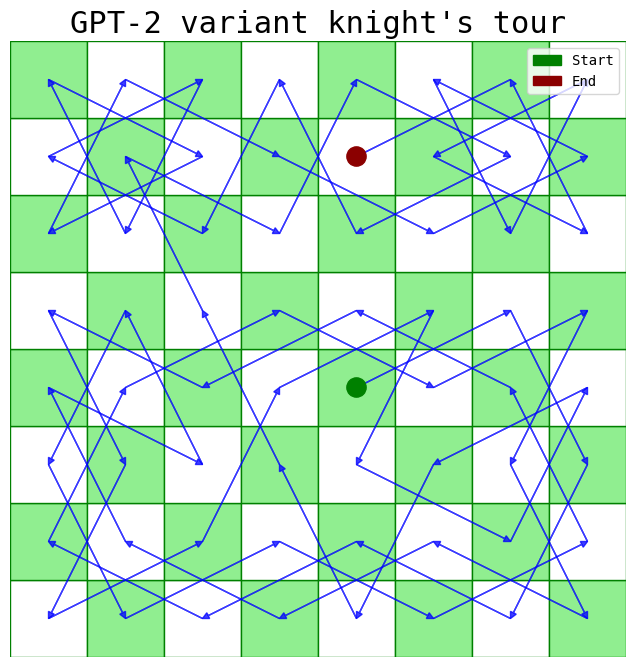

In [46]:
plot_knights_tour(
    generated_moves,
    save=True,
    save_path="./parberry_example3_model3.png"
)

### saving images of "standard" tours

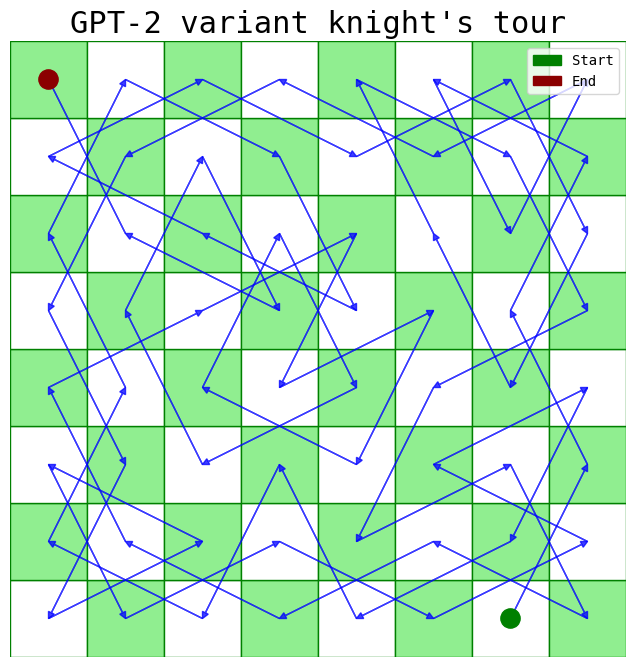

In [58]:
# from the ninth index
random_id = np.random.randint(len(model3_results))
plot_knights_tour(
    model3_results["tour"][random_id],
    save=True,
    save_path="./standard_example4_model3.png"
)